<a href="https://colab.research.google.com/github/superbunny38/2021DeepLearning/blob/main/papers/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### On my journey to understand SC-FEGAN

# U-Net: end-to-end fully convolutional network
symmetric U-shaped network.

[First path]

contraction path(encoder): capture the context in the image.

[Second path]

symmetric expanding path(decoder): 
used to enable precise localization using transposed convolutions.


[summary]

Input (128x128x1) => Encoder =>(8x8x256) => Decoder =>Ouput (128x128x1)

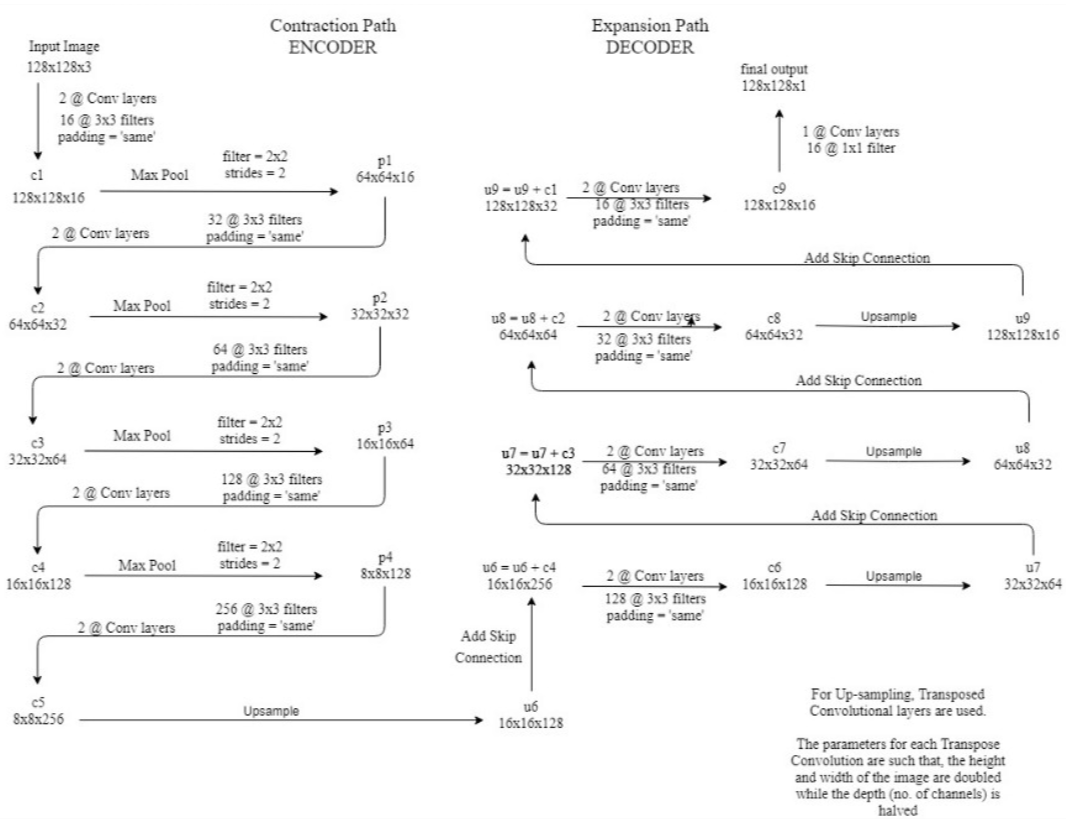

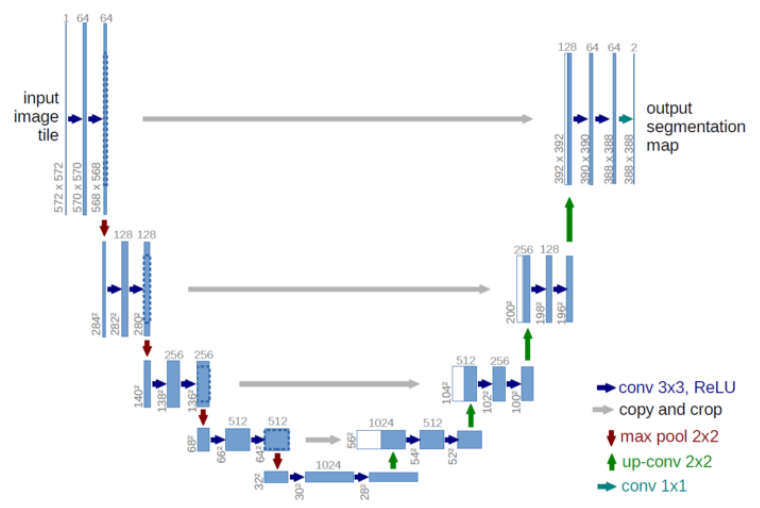

Grey arrow:

To get better precise locations, at every step of the decoder we use skip connections by concatenating the output of the transposed convolution layers with the feature maps from the Encoder at the same level:

u6 = u6 + c4

u7 = u7 + c3

u8 = u8 + c2

u9 = u9 + c1

# U-Net Implementation in pytorch



```
import torch
from torch import nn
import torchvision.transforms
import torch.nn.functional as F

class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out
```



paper:

https://arxiv.org/pdf/1505.04597v1.pdf


reference:

https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

https://amaarora.github.io/2020/09/13/unet.html

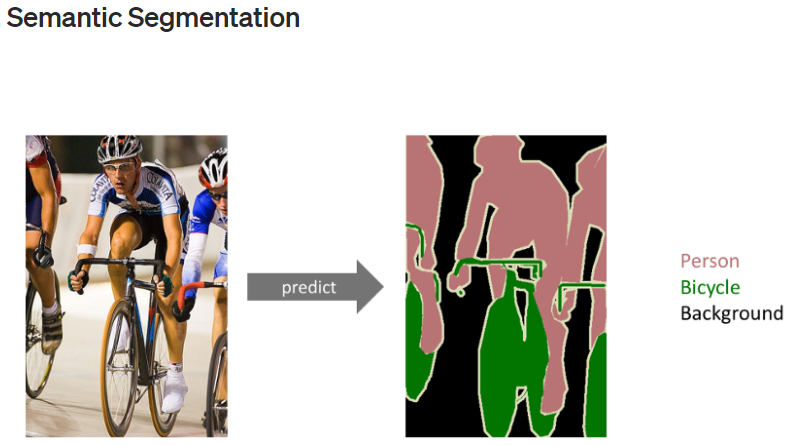

The goal of semantic image segmentation is to label each pixel of an image with a corresponding class of what is being represented. Because we’re predicting for every pixel in the image, this task is commonly referred to as dense prediction.

The output itself is a high resolution image (typically of the same size as input image) in which each pixel is classified to a particular class. Thus it is a pixel level image classification.

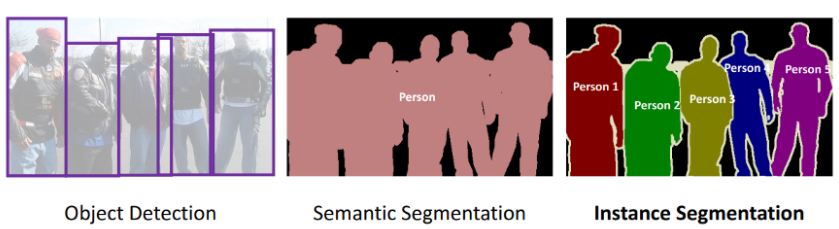

- receptive field (context): the area of the input image that the filter covers at any given point of time.
- down sampling: converting a high resolution image to a low resolution image(reduce the size of the image). -> helps the filters in the deeper layers to focus on a larger receptive field (context)
- up sampling: convert a low resolution image to a high resolution image to recover the “WHERE” information.
- Transposed Convolution(aka. deconvolution, fractionally strided convolution): a technique to perform up sampling of an image with learnable parameters.(https://naokishibuya.medium.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) the input volume of transposed convolution is a low resolution image and the output volume is a high resolution image.

# Solve the Semantic Segmentation problem using Fully Convolutional Network (FCN) called UNET.

import libraries

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

### get dataset

In [8]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 2.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=4a6eabeca7a3297dc1e88c12d80ea550da940016b8da0527b6acba8916222f9a
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c tgs-salt-identification-challenge

  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 38.7MB/s]
 80% 33.0M/41.4M [00:00<00:00, 25.8MB/s]
100% 41.4M/41.4M [00:00<00:00, 47.4MB/s]
  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 99.9MB/s]
 93% 201M/217M [00:01<00:00, 79.5MB/s]
100% 217M/217M [00:01<00:00, 115MB/s] 
 98% 37.0M/37.9M [00:00<00:00, 31.5MB/s]
100% 37.9M/37.9M [00:00<00:00, 70.3MB/s]
 94% 153M/163M [00:01<00:00, 112MB/s]
100% 163M/163M [00:01<00:00, 141MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 101MB/s]


In [6]:
!unzip /content/tgs-salt-identification-challenge.zip

unzip:  cannot find or open /content/tgs-salt-identification-challenge.zip, /content/tgs-salt-identification-challenge.zip.zip or /content/tgs-salt-identification-challenge.zip.ZIP.


In [7]:
!mkdir train_data

In [ ]:
!unzip /content/train.zip -d /content/train_data

#### visualize train_data directory

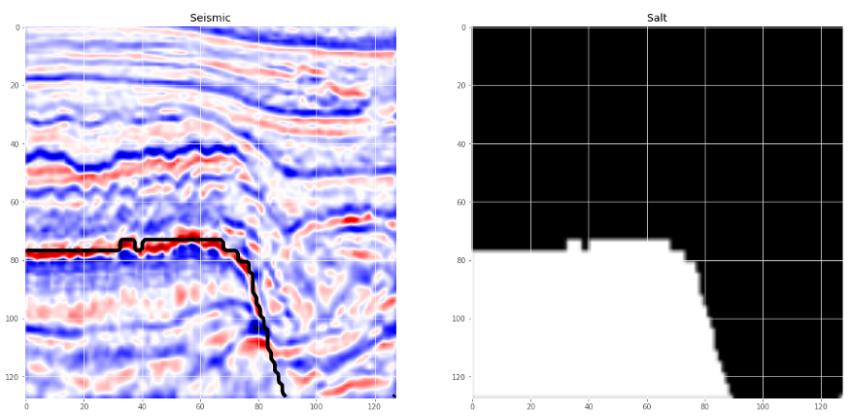

images: seismic images folder

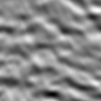

In [119]:
from PIL import Image
img = Image.open('/content/train_data/images/000e218f21.png')
img

In [10]:
img.size

(101, 101)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


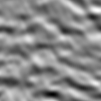

In [120]:
to_number = load_img('/content/train_data/images/000e218f21.png', grayscale=True)
to_number

mask: ground truth label
(white: salt, black: no salt)

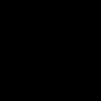

In [11]:
Image.open("/content/train_data/masks/000e218f21.png")

### define U-Net model

In [3]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [4]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [5]:
im_width = 128
im_height = 128
border = 5

In [6]:
!ls

competition_data.zip  kaggle.json	     test.zip	 train.zip
depths.csv	      sample_data	     train.csv
flamingo.zip	      sample_submission.csv  train_data


In [7]:
%cd train_data

/content/train_data


In [8]:
!ls

images	masks


In [9]:
ids = next(os.walk("images"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  4000


In [10]:
ids[:5]

['21df07989f.png',
 'd3c9529867.png',
 'e0b6a1211f.png',
 '8164beeaf5.png',
 'c26d515fdb.png']

In [11]:
ids = sorted(ids)

In [12]:
ids2 = next(os.walk("masks"))[2]

In [13]:
ids2 = sorted(ids2)

In [14]:
ids == ids2

True

In [15]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [16]:
# tqdm is used to display the progress bar
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("images/"+id_, color_mode = "grayscale")
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = load_img("masks/"+id_, color_mode = "grayscale")
    mask = img_to_array(mask)
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0
    #print(np.any(mask>255))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/4000 [00:00<?, ?it/s]

In [17]:
X.shape

(4000, 128, 128, 1)

In [18]:
X#normalized

array([[[[0.41107604],
         [0.4595435 ],
         [0.4595435 ],
         ...,
         [0.34250626],
         [0.35634628],
         [0.32948843]],

        [[0.4595435 ],
         [0.5137255 ],
         [0.51752675],
         ...,
         [0.3546678 ],
         [0.36972076],
         [0.34435615]],

        [[0.46617576],
         [0.5211397 ],
         [0.52582425],
         ...,
         [0.32765305],
         [0.34104955],
         [0.3183342 ]],

        ...,

        [[0.4985148 ],
         [0.55811894],
         [0.5592766 ],
         ...,
         [0.41314632],
         [0.40484068],
         [0.35494858]],

        [[0.50736696],
         [0.554056  ],
         [0.544365  ],
         ...,
         [0.48538825],
         [0.48089594],
         [0.4252586 ]],

        [[0.4581458 ],
         [0.49058077],
         [0.47395906],
         ...,
         [0.48594916],
         [0.48760724],
         [0.4361799 ]]],


       [[[0.59307915],
         [0.6725976 ],
         [0.67

In [19]:
y.shape

(4000, 128, 128, 1)

In [20]:
y

array([[[[  0.     ],
         [  0.     ],
         [  0.     ],
         ...,
         [  0.     ],
         [  0.     ],
         [  0.     ]],

        [[  0.     ],
         [  0.     ],
         [  0.     ],
         ...,
         [  0.     ],
         [  0.     ],
         [  0.     ]],

        [[  0.     ],
         [  0.     ],
         [  0.     ],
         ...,
         [  0.     ],
         [  0.     ],
         [  0.     ]],

        ...,

        [[  0.     ],
         [  0.     ],
         [  0.     ],
         ...,
         [  0.     ],
         [  0.     ],
         [  0.     ]],

        [[  0.     ],
         [  0.     ],
         [  0.     ],
         ...,
         [  0.     ],
         [  0.     ],
         [  0.     ]],

        [[  0.     ],
         [  0.     ],
         [  0.     ],
         ...,
         [  0.     ],
         [  0.     ],
         [  0.     ]]],


       [[[  0.     ],
         [  0.     ],
         [  0.     ],
         ...,
         [229.89

In [21]:
len(y)

4000

In [22]:
y.shape

(4000, 128, 128, 1)

In [31]:
count = 0
for a in y:
  for b in a:
    for c in b:
      for d in c:
        if d> 255.0:
          d = 255.0

In [32]:
y = y/255.0

In [33]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [34]:
X_train.shape

(3600, 128, 128, 1)

In [35]:
y_train.shape

(3600, 128, 128, 1)

In [36]:
X_train[0][0]

array([[0.31693646],
       [0.3710907 ],
       [0.34901518],
       [0.32765222],
       [0.36310184],
       [0.3907819 ],
       [0.45596704],
       [0.49111518],
       [0.48312634],
       [0.4526783 ],
       [0.40845877],
       [0.34201294],
       [0.28511813],
       [0.28707767],
       [0.4476219 ],
       [0.43135646],
       [0.35716847],
       [0.3165802 ],
       [0.35952538],
       [0.3733654 ],
       [0.34690493],
       [0.32510346],
       [0.32373315],
       [0.34985107],
       [0.39690712],
       [0.39167258],
       [0.33776504],
       [0.27571788],
       [0.28402188],
       [0.30868727],
       [0.25213504],
       [0.19099228],
       [0.18359268],
       [0.2666328 ],
       [0.30911207],
       [0.32811812],
       [0.3501388 ],
       [0.39789376],
       [0.47262987],
       [0.46535358],
       [0.38549253],
       [0.33449   ],
       [0.43831757],
       [0.51305366],
       [0.42858845],
       [0.32954323],
       [0.30264425],
       [0.407

In [38]:
y_train

array([[[[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [0.       ],
         [0.       ],
         [0.       ]],

        [[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [0.       ],
         [0.       ],
         [0.       ]],

        [[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [0.       ],
         [0.       ],
         [0.       ]],

        ...,

        [[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [0.       ],
         [0.       ],
         [0.       ]],

        [[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [0.       ],
         [0.       ],
         [0.       ]],

        [[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [0.       ],
         [0.       ],
         [0.       ]]],


       [[[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [0.9015

not salt



Text(0.5, 1.0, 'Salt')

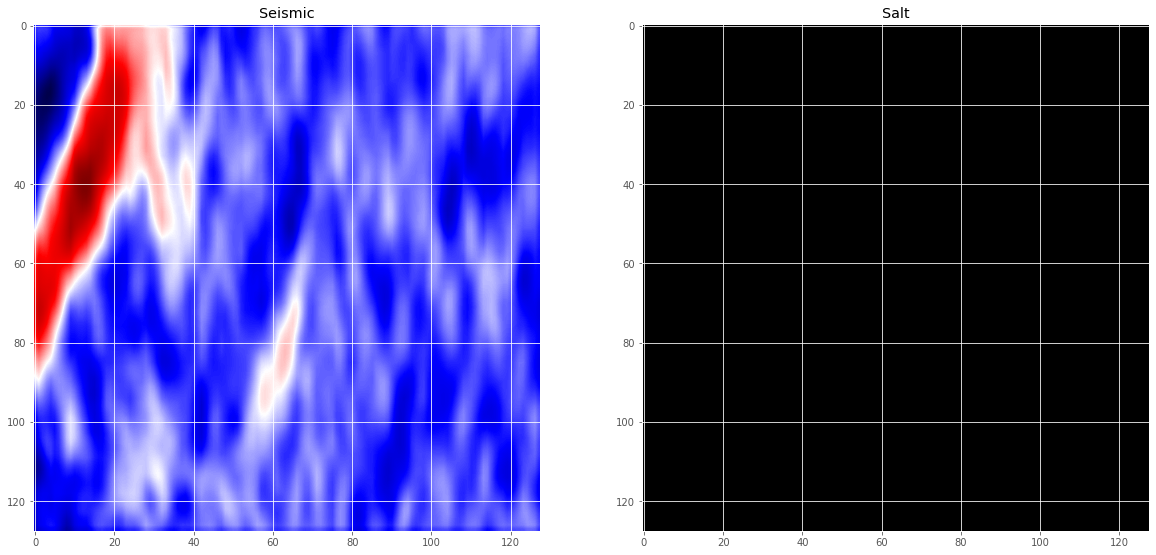

In [89]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
else:
  print("not salt\n")
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

Text(0.5, 1.0, 'Salt')

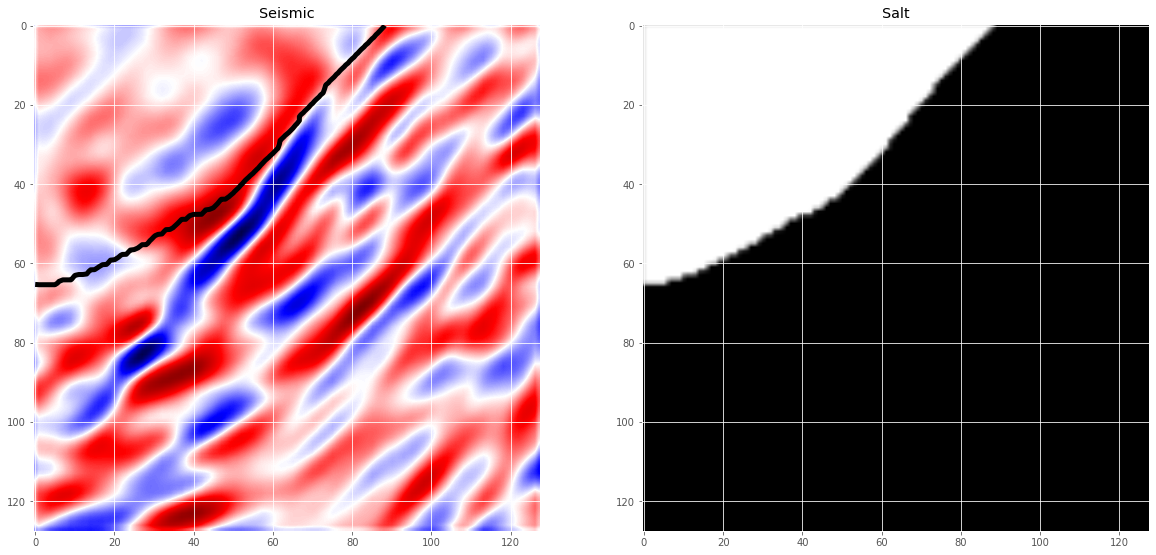

In [90]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
else:
  print("not salt")
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

Text(0.5, 1.0, 'Salt')

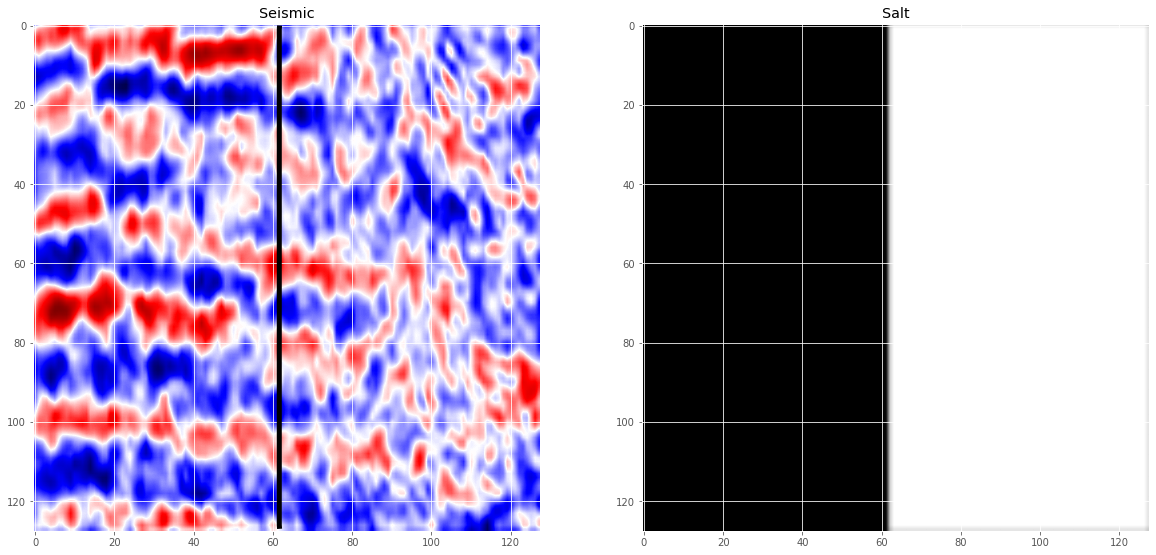

In [91]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
else:
  print("not salt\n")
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

### Compile and Train Model

In [39]:
input_img = Input((im_height, im_width, 1), name='img')

In [93]:
input_img

<KerasTensor: shape=(None, 128, 128, 1) dtype=float32 (created by layer 'img')>

In [47]:
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [48]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_39 (Conv2D)             (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_37 (BatchN  (None, 128, 128, 16  64         ['conv2d_39[0][0]']              
 ormalization)                  )                                                           

In [49]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [50]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Epoch 1/50
112/113 [============================>.] - ETA: 0s - loss: 0.4337 - accuracy: 0.6546
Epoch 00001: val_loss improved from inf to 5.98934, saving model to model-tgs-salt.h5
113/113 [==============================] - 10s 71ms/step - loss: 0.4332 - accuracy: 0.6551 - val_loss: 5.9893 - val_accuracy: 0.1331 - lr: 0.0010
Epoch 2/50
112/113 [============================>.] - ETA: 0s - loss: 0.3045 - accuracy: 0.7071
Epoch 00002: val_loss improved from 5.98934 to 1.21100, saving model to model-tgs-salt.h5
113/113 [==============================] - 8s 67ms/step - loss: 0.3055 - accuracy: 0.7071 - val_loss: 1.2110 - val_accuracy: 0.3895 - lr: 0.0010
Epoch 3/50
112/113 [============================>.] - ETA: 0s - loss: 0.2815 - accuracy: 0.7099
Epoch 00003: val_loss improved from 1.21100 to 0.58521, saving model to model-tgs-salt.h5
113/113 [==============================] - 8s 68ms/step - loss: 0.2814 - accuracy: 0.7100 - val_loss: 0.5852 - val_accuracy: 0.5565 - lr: 0.0010
Epoch 4/50

### display performance

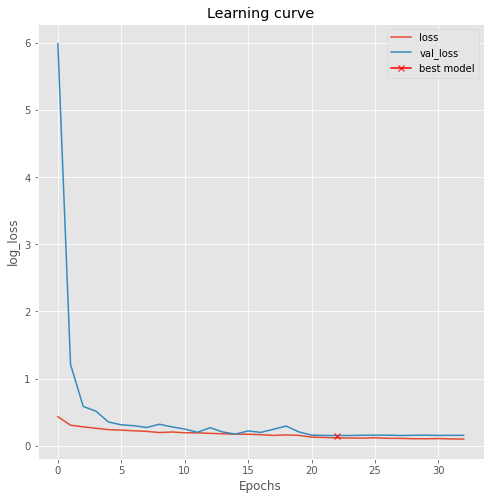

In [51]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### result

In [52]:
# load the best model
model.load_weights('model-tgs-salt.h5')

In [53]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

13/13 [==============================] - 0s 25ms/step - loss: 0.1518 - accuracy: 0.7390


[0.15184809267520905, 0.7389768958091736]

### Predictions

In [54]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

13/13 [==============================] - 0s 16ms/step


In [55]:
#binary
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

Visualize results on training set

In [59]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt(target)')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

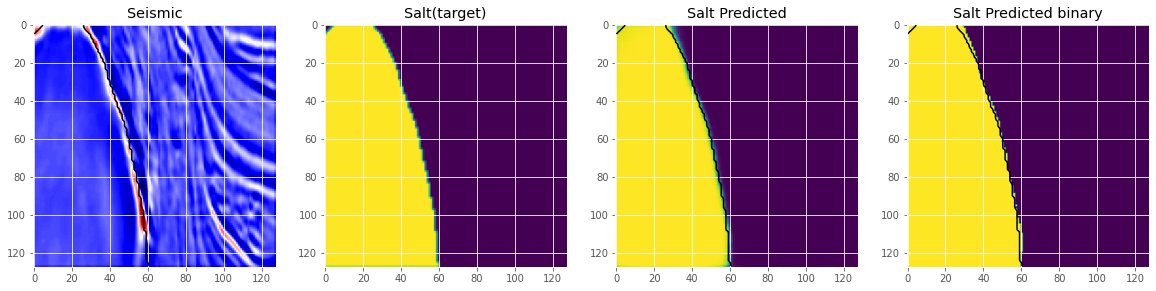

In [60]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

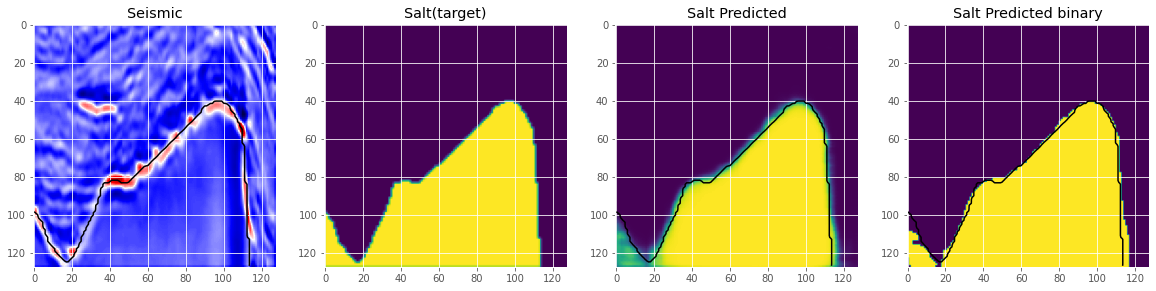

In [62]:
plot_sample(X_train, y_train, preds_train, preds_train_t)